In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import warnings
import sys
import copy

from astropy.utils.exceptions import AstropyWarning # 汎用的な警告クラスをインポート
from matplotlib.ticker import MultipleLocator # 補助グリッドのためにインポート

sys.path.append("/home/filament/fujimoto/Cygnus-X_CAE/data/process_tools")

from Astronomy import del_header_key
import cut_resize_tools

In [3]:
def plot_fits_with_grid(fits_path, grid_spacing=64):
    """
    2次元FITSファイルを読み込み、WCS座標で画像をプロットし、グリッドを描画します。
    (Astropyのバージョン互換性を改善した版)
    """
    try:
        with fits.open(fits_path) as hdul:
            image_hdu = hdul[0]
            data = image_hdu.data

            if data.ndim != 2:
                print(f"エラー: このプログラムは2次元のFITSデータのみ対応しています。入力データは {data.ndim}次元です。")
                return

            # --- 警告処理の修正 ---
            # Astropyに関する警告を一時的に無視してWCS情報を読み込む
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', AstropyWarning)
                wcs_info = WCS(image_hdu.header)
            
            height, width = data.shape

            # --- 描画処理 (変更なし) ---
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(1, 1, 1, projection=wcs_info)

            im = ax.imshow(
                data,
                origin='lower',
                cmap='viridis',
                vmin=np.nanpercentile(data, 5),
                vmax=np.nanpercentile(data, 99.5)
            )

            x_ticks = np.arange(0, width, grid_spacing)
            y_ticks = np.arange(0, height, grid_spacing)

            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.grid(color='white', linestyle='--', linewidth=0.7, alpha=0.8)

            ax.set_xlabel('Right Ascension')
            ax.set_ylabel('Declination')
            ax.set_title(f'FITS Image with {grid_spacing}-Pixel Grid')

            fig.colorbar(im, ax=ax, label='Pixel Intensity')

            output_filename = 'fits_image_with_grid.png'
            plt.savefig(output_filename, bbox_inches='tight', dpi=150)
            print(f"✅ 画像を '{output_filename}' として保存しました。")
            plt.close(fig)

    except FileNotFoundError:
        print(f"エラー: ファイル '{fits_path}' が見つかりません。")
    except Exception as e:
        print(f"予期せぬエラーが発生しました: {e}")

In [4]:
fits_path = "/home/filament/fujimoto/Cygnus-X_CAE/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]

raw_d = hdu.data
header = hdu.header

Changed DATE-OBS from '2016-01-13        ' to '2016-01-13T00:00:00.0''. [astropy.wcs.wcs]


In [5]:
len(raw_d)

320

In [6]:
vsmooth = 5
thresh = 1
sigma = 2
sch_rms = 10
ech_rms = 90
sch_ii = 141
ech_ii = 220
percentile = 99.997
# sigma_multiply = 15

cut_size_list = [256, 128, 64]
integrate_layer_num = 20
obj_size = 100
maximum_mode = "percentile"

In [7]:
all_map = raw_d.copy()
all_map = cut_resize_tools.process_data_segment(all_map, vsmooth, sch_rms, ech_rms, sch_ii, ech_ii, sigma, thresh, integrate_layer_num)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
new_data = np.nansum(all_map, axis=0) * np.abs(header["CDELT3"]) / 1000.0
header2 = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
header2["NAXIS"] = 2
new_hdu = fits.PrimaryHDU(new_data, header2)

In [9]:
output_path = "/home/filament/fujimoto/Cygnus-X_CAE/fits/processed_fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb_processed.fits"

# HDUListオブジェクトのwriteto()メソッドでファイルに書き出す
new_hdu.writeto(output_path, overwrite=True)

In [10]:
new_hdu =  fits.open("/home/filament/fujimoto/Cygnus-X_CAE/fits/processed_fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb_processed.fits")[0]

In [11]:
wcs_info = WCS(new_hdu.header)
data = new_hdu.data

In [12]:
data[data == 0] = np.nan

In [17]:
origin_sum_data = np.nansum(raw_d, axis=0)
origin_sum_data[origin_sum_data == 0] = np.nan

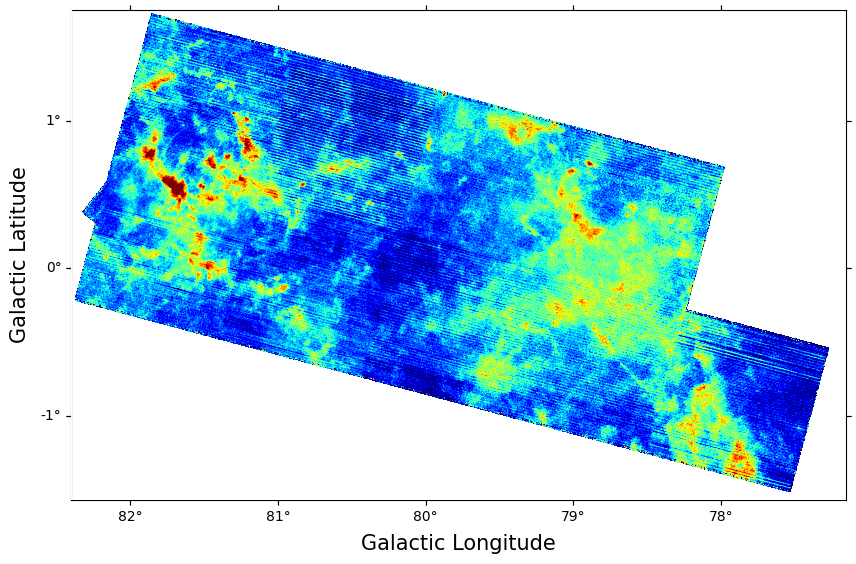

In [18]:
grid_spacing = 20000

height, width = data.shape

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=wcs_info)

cmap = copy.copy(plt.get_cmap('jet'))

# 2. NaNなど不正値の色を白に設定
cmap.set_bad(color='white')
# --- 変更箇所ここまで ---

im = ax.imshow(
    origin_sum_data,
    origin='lower',
    cmap=cmap, # 設定を変更したカラーマップを渡す
    vmin=np.nanpercentile(origin_sum_data, 5),
    vmax=np.nanpercentile(origin_sum_data, 99.7)
)

minor_spacing = grid_spacing / 4
minor_ticks_x = np.arange(0, width, minor_spacing)
minor_ticks_y = np.arange(0, height, minor_spacing)

for x_pos in minor_ticks_x:
    ax.axvline(x_pos, color='white', linestyle=':', linewidth=0.7, alpha=0.9)
for y_pos in minor_ticks_y:
    ax.axhline(y_pos, color='white', linestyle=':', linewidth=0.7, alpha=0.9)

# 2. 主グリッド（実線）を上から描画
major_ticks_x = np.arange(0, width, grid_spacing)
major_ticks_y = np.arange(0, height, grid_spacing)

for x_pos in major_ticks_x:
    ax.axvline(x_pos, color='white', linestyle='-', linewidth=0.9, alpha=1)
for y_pos in major_ticks_y:
    ax.axhline(y_pos, color='white', linestyle='-', linewidth=0.9, alpha=1)

ax.set_xlabel('Galactic Longitude', fontsize=15)
ax.set_ylabel('Galactic Latitude', fontsize=15)
# ax.set_title(f'FITS Image with {grid_spacing}-Pixel Grid')

# fig.colorbar(im, ax=ax, label='Pixel Intensity')
plt.savefig("Cygnus-X_no_grid_jet", )
plt.show()